- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")
from src.functions_torch import TransformLag
from src.feature import TimeConfig


In [2]:
df= TimeConfig.process_chain(path='../Data/apple.csv',columns=['Close/Last'])


In [3]:
df

,Value
Date,
2014-05-30,22.6072
2014-06-02,22.4518
2014-06-03,22.7693
2014-06-04,23.0293
2014-06-05,23.1197
...,...
2024-05-22,190.9000
2024-05-23,186.8800
2024-05-24,189.9800


In [4]:
df= df.loc['2023':'2024'].copy()

In [5]:
df


,Value
Date,
2023-01-03,125.07
2023-01-04,126.36
2023-01-05,125.02
2023-01-06,129.62
2023-01-09,130.15
...,...
2024-05-22,190.90
2024-05-23,186.88
2024-05-24,189.98


- Plotting the Data

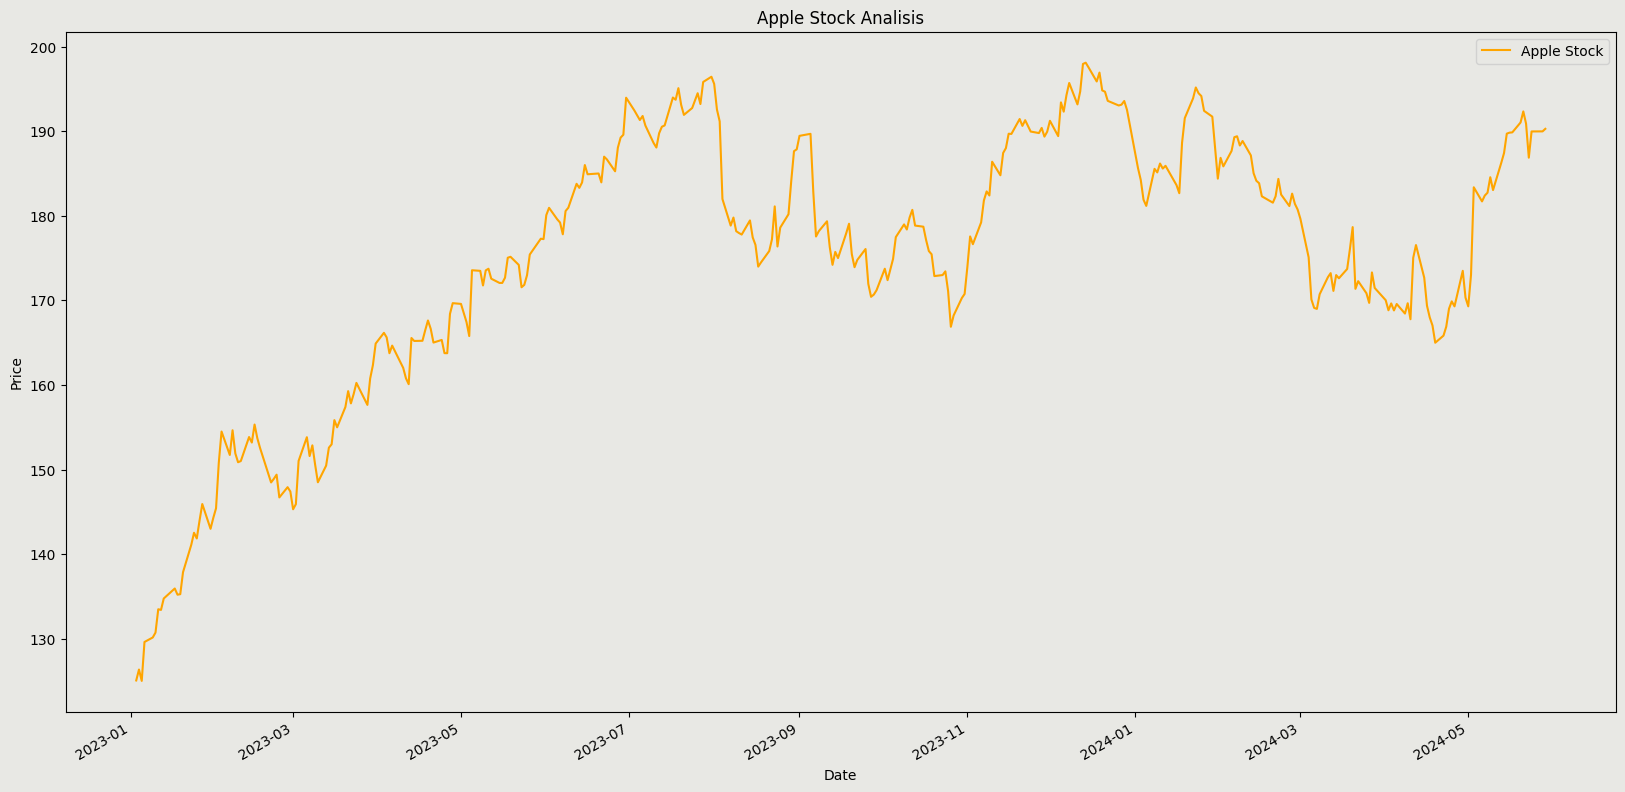

In [6]:
df["Value"].plot(figsize=(20,10),label="Apple Stock",color="orange")
plt.title("Apple Stock Analisis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_facecolor("#E8E8E4")
plt.gcf().set_facecolor("#E8E8E4")
plt.legend(facecolor="#E8E8E4")
plt.show()

In [7]:
data= TransformLag.lag_transform(df,10)

In [8]:
data= data.to_numpy()

In [9]:
data

array([[135.21, 135.94, 134.76, ..., 125.02, 126.36, 125.07],
       [135.27, 135.21, 135.94, ..., 129.62, 125.02, 126.36],
       [137.87, 135.27, 135.21, ..., 130.15, 129.62, 125.02],
       ...,
       [189.98, 186.88, 190.9 , ..., 187.43, 186.28, 183.05],
       [189.99, 189.98, 186.88, ..., 189.72, 187.43, 186.28],
       [190.29, 189.99, 189.98, ..., 189.84, 189.72, 187.43]])

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [10]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)
transformed

array([[-1.        , -0.97678855, -1.        , ..., -1.        ,
        -0.96333288, -0.99863182],
       [-0.99809221, -1.        , -0.96274665, ..., -0.87412779,
        -1.        , -0.96333288],
       [-0.9154213 , -0.99809221, -0.98579321, ..., -0.85962512,
        -0.87412779, -1.        ],
       ...,
       [ 0.74149444,  0.64292528,  0.77237569, ...,  0.70775756,
         0.67628951,  0.58790532],
       [ 0.7418124 ,  0.74149444,  0.64546172, ...,  0.77042003,
         0.70775756,  0.67628951],
       [ 0.75135135,  0.7418124 ,  0.7433307 , ...,  0.77370365,
         0.77042003,  0.70775756]])

- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [11]:
X= transformed[:,1:]
y= transformed[:,0]
X= dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.90)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]
X_train= X_train.reshape((-1,10,1))
X_test= X_test.reshape((-1,10,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [12]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]

batch_size =16
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [13]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([16, 10, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [14]:
def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss
    #     if batch_index % 100 == 99:  # print every 100 batches
    #         avg_loss_across_batches = running_loss / 100
    #         print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
    #                                                 avg_loss_across_batches))
    #         running_loss = 0.0
    # print()
    
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    return avg_loss_across_batches

    # print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    # print('***************************************************')
    # print()

Epoch 1/50, Train Loss: 0.3021364377013275, Validation Loss: 0.29159180726855993
Epoch 2/50, Train Loss: 0.22198409879846231, Validation Loss: 0.19621455390006304
Epoch 3/50, Train Loss: 0.1737903290029083, Validation Loss: 0.14029918564483523
Epoch 4/50, Train Loss: 0.14948439092508384, Validation Loss: 0.10669458843767643
Epoch 5/50, Train Loss: 0.13582794647663832, Validation Loss: 0.0902036502957344
Epoch 6/50, Train Loss: 0.12588902775730407, Validation Loss: 0.08047014009207487
Epoch 7/50, Train Loss: 0.11598088898296867, Validation Loss: 0.07186807040125132
Epoch 8/50, Train Loss: 0.10487824359110423, Validation Loss: 0.0654372526332736
Epoch 9/50, Train Loss: 0.09241424155022417, Validation Loss: 0.05782338045537472
Epoch 10/50, Train Loss: 0.07898832611473543, Validation Loss: 0.0495127784088254
Epoch 11/50, Train Loss: 0.06518012079011117, Validation Loss: 0.04162720311433077
Epoch 12/50, Train Loss: 0.051167197026578445, Validation Loss: 0.033434219658374786
Epoch 13/50, Tra

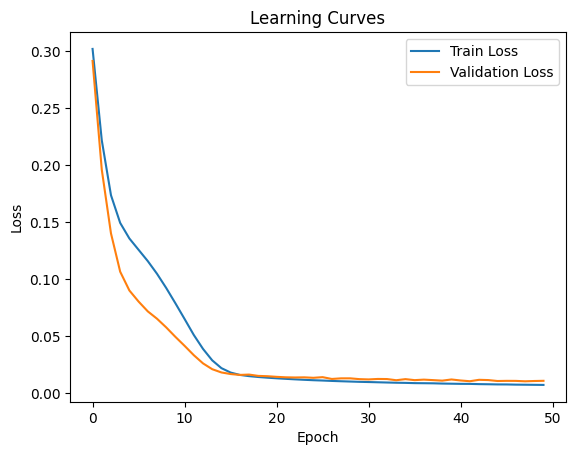

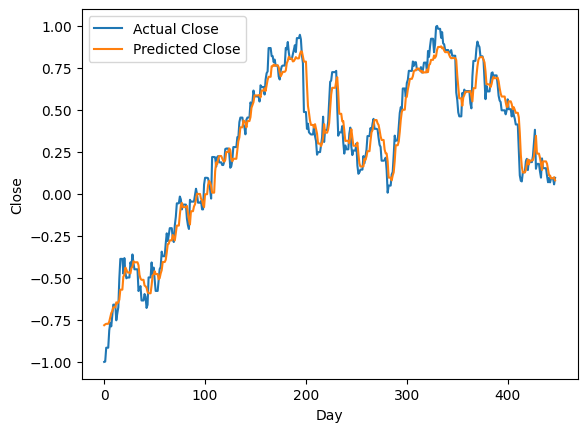

In [15]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    val_loss= validate_one_epoch()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

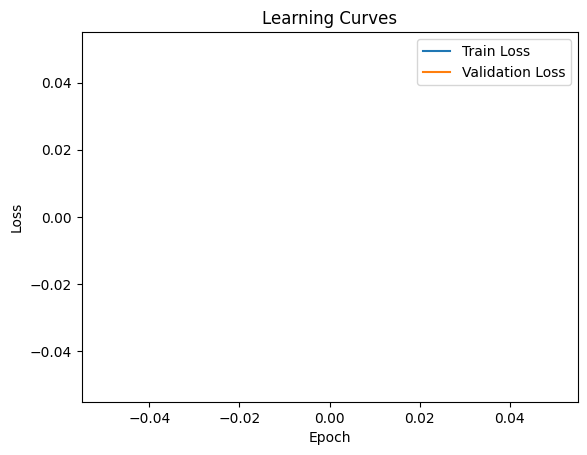

In [16]:
# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [16]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 10+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([144.13621877, 144.30183856, 144.38843039, 144.38843039,
       144.38843039, 144.45606848, 144.70112301, 145.09999693,
       145.44208649, 145.82878323, 145.82878323, 145.82878323,
       146.38624544, 146.62158971, 146.81042225, 147.08956764,
       148.05441429, 148.05441429, 148.05441429, 149.73847572,
       150.67332932, 152.05139033, 152.52912724, 152.53908775,
       152.53908775, 152.53908775, 152.51985658, 153.15001165,
       153.44692042, 154.20330971, 154.37001112, 154.37001112,
       154.37001112, 154.37001112, 154.15945704, 152.94619758,
       152.08526936, 151.54675995, 151.54675995, 151.54675995,
       150.59217186, 150.06399037, 149.64217364, 149.01555681,
       148.6432305 , 148.6432305 , 148.6432305 , 149.24750812,
       150.49014672, 151.10040609, 151.8526179 , 151.94567043,
       151.94567043, 151.94567043, 151.48423099, 151.49610449,
       151.99387489, 152.47713709, 153.60835055, 153.60835055,
       153.60835055, 154.34194043, 155.65787082, 157.37

In [17]:
dummies = np.zeros((X_train.shape[0], 10+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([135.21      , 135.26999924, 137.86999989, 137.86999989,
       137.86999989, 141.1099999 , 142.53000058, 141.86000067,
       143.96000019, 145.93000042, 145.93000042, 145.93000042,
       142.99999928, 144.29000067, 145.42999929, 150.81999912,
       154.50000009, 154.50000009, 154.50000009, 151.72999972,
       154.65000006, 151.92000012, 150.86999942, 151.01000045,
       151.01000045, 151.01000045, 153.84999993, 153.19999976,
       155.32999984, 153.70999983, 152.5499996 , 152.5499996 ,
       152.5499996 , 152.5499996 , 148.48000078, 148.90999999,
       149.40000032, 146.70999987, 146.70999987, 146.70999987,
       147.92000041, 147.41000034, 145.31000082, 145.91000068,
       151.0300002 , 151.0300002 , 151.0300002 , 153.83000018,
       151.60000044, 152.87000021, 150.58999924, 148.50000053,
       148.50000053, 148.50000053, 150.47000076, 152.59000003,
       152.98999962, 155.84999978, 155.00000029, 155.00000029,
       155.00000029, 157.39999974, 159.28000019, 157.82

In [18]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 10+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([170.37254531, 169.83551869, 172.48739889, 172.48739889,
       172.48739889, 174.91489636, 174.86017215, 173.24233539,
       171.41368025, 169.73757167, 169.73757167, 169.73757167,
       167.83579064, 167.0576114 , 167.22813599, 168.37067933,
       169.72321249, 169.72321249, 169.72321249, 170.41331338,
       172.46846765, 172.48043863, 171.87227972, 172.89204648,
       172.89204648, 172.89204648, 177.56983867, 180.0345294 ,
       181.73886425, 182.84859894, 184.04750017, 184.04750017,
       184.04750017, 184.14407406, 185.22798566, 186.27525324,
       187.64656581, 188.57945112, 188.57945112, 188.57945112,
       189.20555619, 189.89667121, 190.66385987, 190.76381173,
       189.68743964, 189.68743964, 189.68743964, 189.68743964,
       189.74676591, 189.7895735 ])

In [19]:
dummies = np.zeros((X_test.shape[0], 10+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([167.78000004, 175.04000021, 176.54999974, 176.54999974,
       176.54999974, 172.69000012, 169.38000007, 168.00000005,
       167.04      , 165.00000004, 165.00000004, 165.00000004,
       165.84000001, 166.90000001, 169.01999996, 169.8899999 ,
       169.29999991, 169.29999991, 169.29999991, 173.50000012,
       170.32999993, 169.29999991, 173.03000001, 183.38000093,
       183.38000093, 183.38000093, 181.70999969, 182.40000028,
       182.7399997 , 184.56999984, 183.05000044, 183.05000044,
       183.05000044, 186.27999964, 187.42999907, 189.72000085,
       189.83999933, 189.86999988, 189.86999988, 189.86999988,
       191.04000093, 192.35000019, 190.90000084, 186.8799995 ,
       189.97999942, 189.97999942, 189.97999942, 189.97999942,
       189.99000023, 190.29000016])

- El modelo puede claramente tener una idea de los patrones de los datos pero no de la escala
- El modelo se ha entrenado con datos muy antiguos que no tienen similitud con los datos actuales, habria que repetir el proceso de transformaciones y re-entrenar el modelo con datos mas recientes

In [20]:
print(test_predictions)

[170.37254531 169.83551869 172.48739889 172.48739889 172.48739889
 174.91489636 174.86017215 173.24233539 171.41368025 169.73757167
 169.73757167 169.73757167 167.83579064 167.0576114  167.22813599
 168.37067933 169.72321249 169.72321249 169.72321249 170.41331338
 172.46846765 172.48043863 171.87227972 172.89204648 172.89204648
 172.89204648 177.56983867 180.0345294  181.73886425 182.84859894
 184.04750017 184.04750017 184.04750017 184.14407406 185.22798566
 186.27525324 187.64656581 188.57945112 188.57945112 188.57945112
 189.20555619 189.89667121 190.66385987 190.76381173 189.68743964
 189.68743964 189.68743964 189.68743964 189.74676591 189.7895735 ]


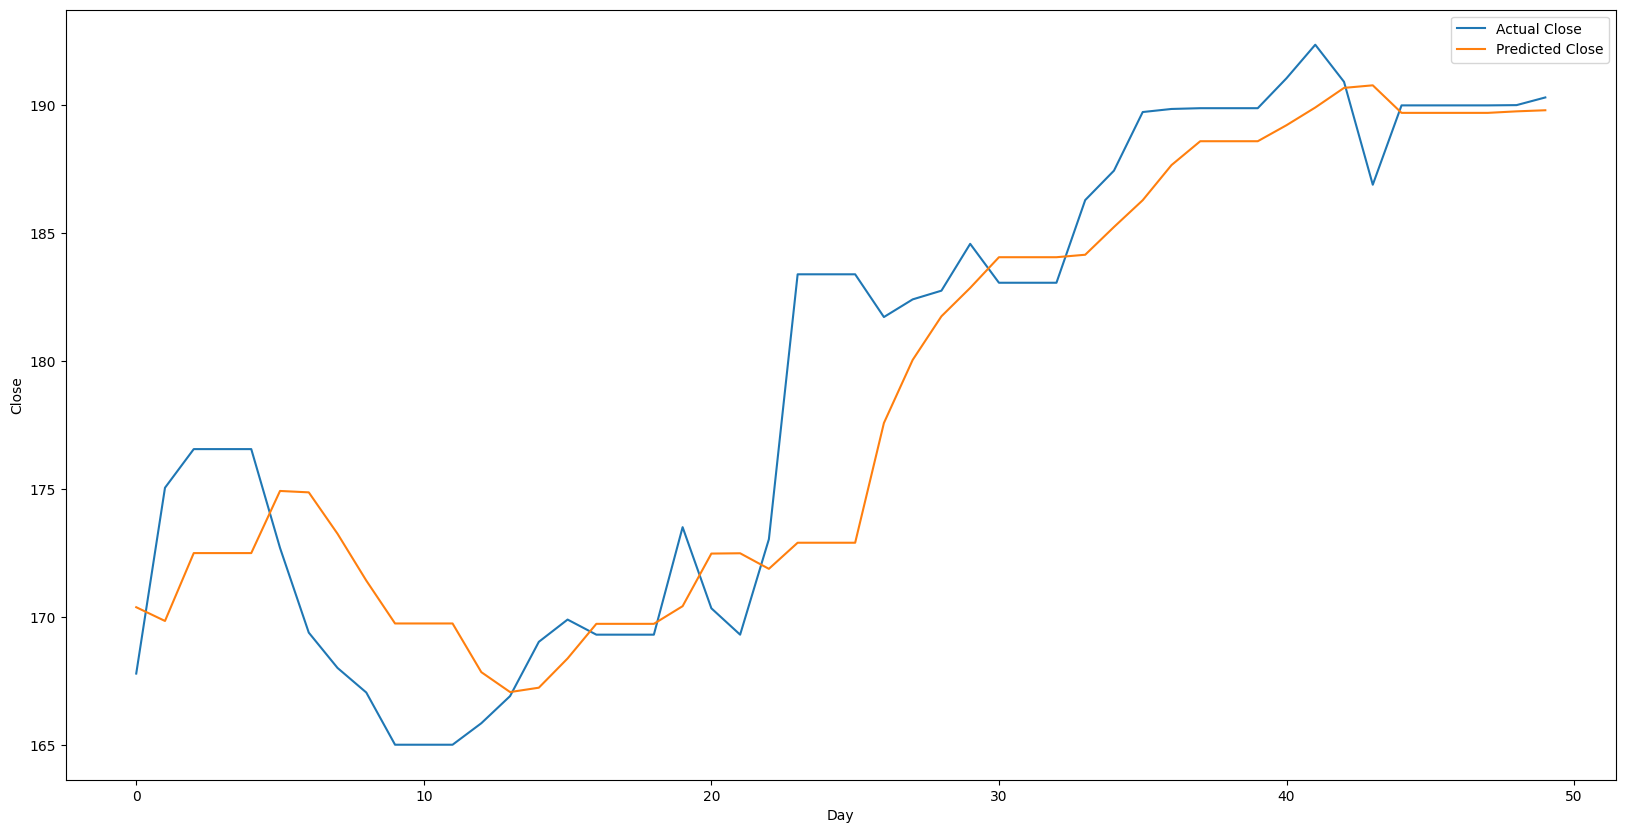

In [21]:
plt.figure(figsize=(20,10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()